In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
# Set the visual style for the plots
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# IMPORTANT: Update this path to your actual results folder
# Example: "wikipedia/experiments/run_20251125_150015/results"
RESULTS_DIR = "wikipedia/experiments/run_20251126_092646/results" 

# --- DATA LOADING ---
try:
    # Load the four CSV files generated by the evaluation script
    df_ctx_global = pd.read_csv(os.path.join(RESULTS_DIR, "contextual_GLOBAL.csv"))
    df_ctx_suffix = pd.read_csv(os.path.join(RESULTS_DIR, "contextual_SUFFIX.csv"))
    df_cf_global = pd.read_csv(os.path.join(RESULTS_DIR, "counterfactual_GLOBAL.csv"))
    df_cf_suffix = pd.read_csv(os.path.join(RESULTS_DIR, "counterfactual_SUFFIX.csv"))
    
    print("✅ All CSV files loaded successfully.")
    
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please check the RESULTS_DIR path.")

# --- DATA PREPROCESSING ---
# Function to extract the repetition count (Frequency) from the canary_id string
# Example: "HighEnt_rep100_0" -> 100
def extract_freq(canary_id):
    if "rep" in canary_id:
        try:
            # Split by '_' and find the part starting with 'rep'
            parts = canary_id.split('_')
            for p in parts:
                if p.startswith('rep'):
                    return int(p.replace('rep', ''))
        except:
            return 0
    return 0

# Apply the extraction to all dataframes
for df in [df_ctx_global, df_ctx_suffix, df_cf_global, df_cf_suffix]:
    df['Frequency'] = df['canary_id'].apply(extract_freq)

print("✅ Frequency column added to all dataframes.")

✅ All CSV files loaded successfully.
✅ Frequency column added to all dataframes.


 Plot 1 - Memorization Dynamics over Time

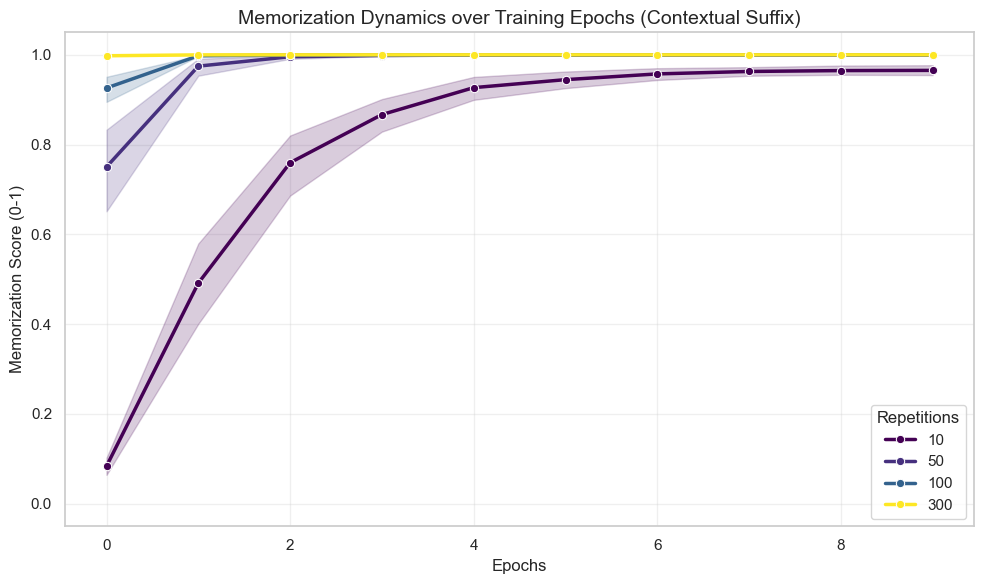

In [4]:
plt.figure(figsize=(10, 6))

# We use the Suffix Loss metric as it is more sensitive
sns.lineplot(
    data=df_ctx_suffix, 
    x="epoch", 
    y="score", 
    hue="Frequency", 
    palette="viridis", 
    marker="o",
    linewidth=2.5
)

plt.title("Memorization Dynamics over Training Epochs (Contextual Suffix)", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Memorization Score (0-1)")
plt.ylim(-0.05, 1.05)  # Set limits to see 0 and 1 clearly
plt.legend(title="Repetitions", loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig("plot_1_memorization_over_time.png", dpi=300)
plt.show()

 Plot 2 - Sensitivity Analysis (Global vs. Suffix Loss)

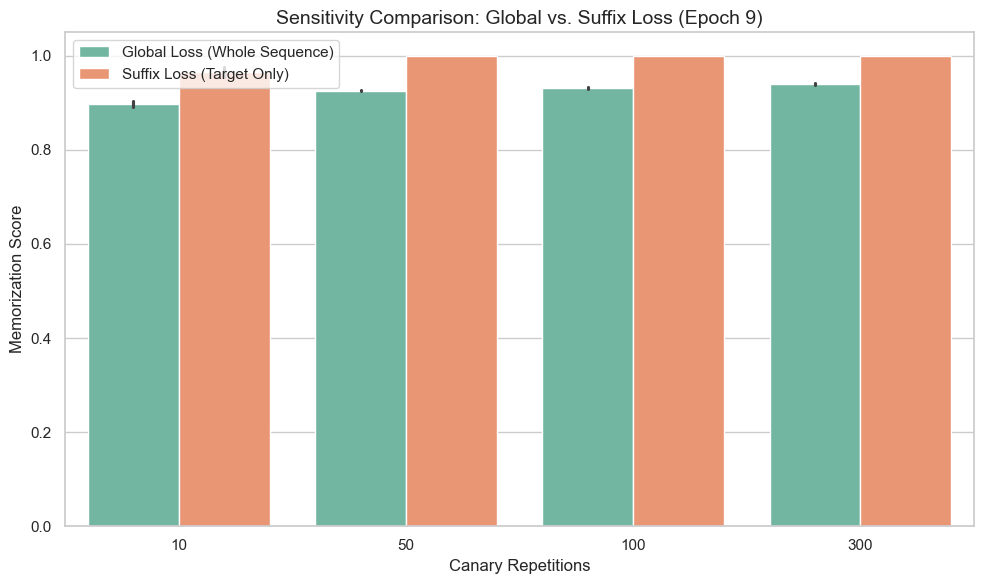

In [5]:
# 1. Select the final epoch for comparison
last_epoch = df_ctx_suffix['epoch'].max()

# 2. Filter data for the last epoch
ctx_global_final = df_ctx_global[df_ctx_global['epoch'] == last_epoch].copy()
ctx_suffix_final = df_ctx_suffix[df_ctx_suffix['epoch'] == last_epoch].copy()

# 3. Label the methods
ctx_global_final['Method'] = 'Global Loss (Whole Sequence)'
ctx_suffix_final['Method'] = 'Suffix Loss (Target Only)'

# 4. Combine into a single dataframe for plotting
comparison_df = pd.concat([ctx_global_final, ctx_suffix_final])

# 5. Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=comparison_df, 
    x="Frequency", 
    y="score", 
    hue="Method",
    palette="Set2"
)

plt.title(f"Sensitivity Comparison: Global vs. Suffix Loss (Epoch {last_epoch})", fontsize=14)
plt.xlabel("Canary Repetitions")
plt.ylabel("Memorization Score")
plt.ylim(0, 1.05)
plt.legend(loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig("plot_2_global_vs_suffix.png", dpi=300)
plt.show()

 Plot 3 - Metric Comparison (Contextual vs. Counterfactual)

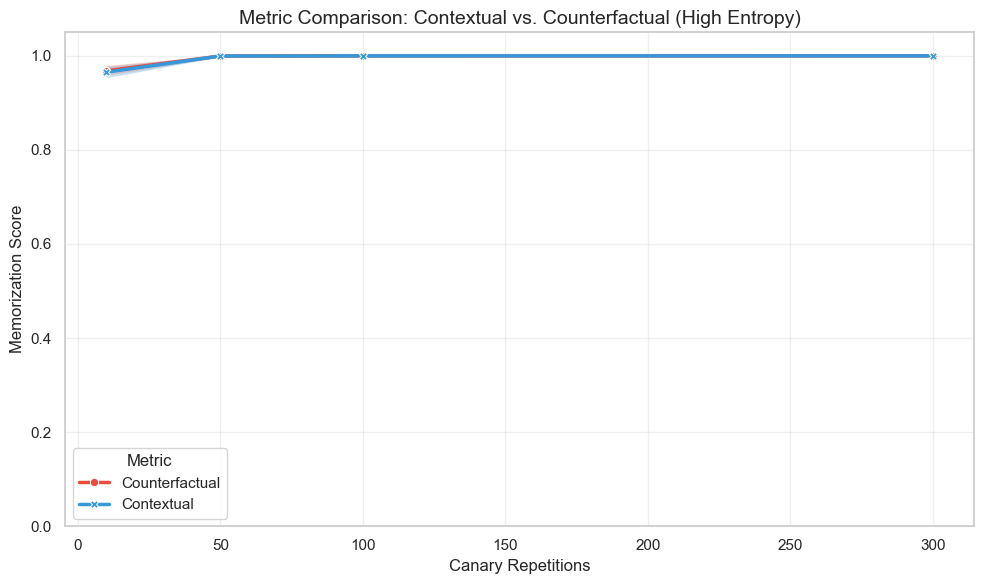

In [6]:
# 1. Filter data for the last epoch (using Suffix loss for both)
cf_suffix_final = df_cf_suffix[df_cf_suffix['epoch'] == last_epoch].copy()
ctx_suffix_final = df_ctx_suffix[df_ctx_suffix['epoch'] == last_epoch].copy()

# 2. Label the metrics
cf_suffix_final['Metric'] = 'Counterfactual'
ctx_suffix_final['Metric'] = 'Contextual'

# 3. Combine
metrics_df = pd.concat([cf_suffix_final, ctx_suffix_final])

# 4. Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=metrics_df, 
    x="Frequency", 
    y="score", 
    hue="Metric",
    style="Metric",
    markers=True,
    dashes=False,
    linewidth=2.5,
    palette=["#e74c3c", "#3498db"] # Red and Blue
)

plt.title("Metric Comparison: Contextual vs. Counterfactual (High Entropy)", fontsize=14)
plt.xlabel("Canary Repetitions")
plt.ylabel("Memorization Score")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig("plot_3_ctx_vs_cf.png", dpi=300)
plt.show()